In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import duckdb 
duckdb.install_extension('json')
duckdb.install_extension('spatial')
duckdb.load_extension('json')
duckdb.load_extension('spatial')

DuckDB database connection

In [2]:
db = duckdb.connect("data.db")
EXTRACT_DATA_TO_DATABASE = False

Utils

In [3]:
def fixStringEncoding(word) -> str:
    if( word is None ):
        return word

    try:
        #based on https://www.i18nqa.com/debug/utf8-debug.html
        return word.encode('ISO-8859-1').decode('utf-8')
    except:
        print(word)


try:
    db.remove_function('fixStringEncoding') 
except:
    print("fixStringEncoding reemoved if existed")

try:
    db.create_function('fixStringEncoding', fixStringEncoding)  
except:
    print("created fixStringEncoding")

fixStringEncoding reemoved if existed


Constants

In [4]:
BASE_PATH = "../tp_data/uncrompressed"

Read accidents data

In [5]:
if(EXTRACT_DATA_TO_DATABASE):
    df_ansr_acidentes               = pd.read_excel(f"{BASE_PATH}/ANSR_ACIDENTES\ANSR_ACIDENTES\ANSR_ACIDENTES_2019_2021.xlsx")
    df_ansr_acidentes_veic_cond     = pd.read_excel(f"{BASE_PATH}/ANSR_ACIDENTES\ANSR_ACIDENTES\ANSR_ACIDENTES_2019_2021.xlsx", sheet_name="veíc-cond")
    df_ansr_acidentes_passageiros   = pd.read_excel(f"{BASE_PATH}/ANSR_ACIDENTES\ANSR_ACIDENTES\ANSR_ACIDENTES_2019_2021.xlsx", sheet_name="passageiros")
    df_ansr_acidentes_peoes         = pd.read_excel(f"{BASE_PATH}/ANSR_ACIDENTES\ANSR_ACIDENTES\ANSR_ACIDENTES_2019_2021.xlsx", sheet_name="peões")

    df_dmm_sinistros_graves = pd.read_excel(f"{BASE_PATH}/DMM_SINISTROS_GRAVES\DMM_SINISTROS_GRAVES\DMM_SINISTROS_GRAVES.xlsx", sheet_name="SinistrosGraves_TabelaAtributos")
    df_rsb_acidentes        = pd.read_csv(f"{BASE_PATH}/rbs_acidentes_rodoviarios\RSB_ACIDENTES RODOVIÁRIOS\RSB_ACIDENTES_RODOVIARIOS_13.12.2018_A_02.09.2022.csv")

Read meteo data

In [6]:
if(EXTRACT_DATA_TO_DATABASE):
    df_meteo_2019       = pd.read_excel(f"{BASE_PATH}/PGIL_IPMA_METEO_OBS\PGIL_IPMA_METEO_OBS\PGIL_IPMA_METEO_OBS_2019\PGIL_IPMA_METEO_OBS_01012019_a_30102019.xlsx")
    df_meteo_2020_2022  = pd.read_csv(f"{BASE_PATH}/PGIL_IPMA_METEO_OBS\PGIL_IPMA_METEO_OBS\PGIL_IPMA_METEO_OBS_16.01.2020_a_08.09.2022.csv")

Read waze jams

In [7]:
if(EXTRACT_DATA_TO_DATABASE):
    df_waze_jams_2017_2018       = pd.read_excel(f"{BASE_PATH}/waze jams\WAZE JAMS\DMM_WAZE_JAMS_29112017_a_31122018\DMM_WAZE_JAMS_2017-11-29 a 2018-10-31.xlsx") 
    df_waze_jams_end_2018        = pd.read_excel(f"{BASE_PATH}/waze jams\WAZE JAMS\DMM_WAZE_JAMS_29112017_a_31122018\DMM_WAZE_JAMS_2018-11-01 a 2018-12-31.xlsx")  
    df_waze_jams_end_2018        = pd.read_excel(f"{BASE_PATH}/waze jams\WAZE JAMS\DMM_WAZE_JAMS_29112017_a_31122018\DMM_WAZE_JAMS_2018-11-01 a 2018-12-31.xlsx") 
    df_waze_jams_2019_2022       = db.sql(f"select * from '{BASE_PATH}/waze jams\WAZE JAMS\PGIL_WAZE_JAMS_01.01.2019_a_31.08.2022\PGIL_WAZE_JAMS_01.01.2019_a_31.08.2022\waze_desafios\*.csv'").to_df()

Insert data frames into duckdb

In [8]:
if(EXTRACT_DATA_TO_DATABASE):
    db.sql("CREATE TABLE IF NOT EXISTS ansr_acidentes               AS SELECT * FROM df_ansr_acidentes")
    db.sql("CREATE TABLE IF NOT EXISTS ansr_acidentes_veic_cond     AS SELECT * FROM df_ansr_acidentes_veic_cond")
    db.sql("CREATE TABLE IF NOT EXISTS ansr_acidentes_passageiros   AS SELECT * FROM df_ansr_acidentes_passageiros")
    db.sql("CREATE TABLE IF NOT EXISTS ansr_acidentes_peoes         AS SELECT * FROM df_ansr_acidentes_peoes")
    db.sql("CREATE TABLE IF NOT EXISTS dmm_sinistros_graves         AS SELECT * FROM df_dmm_sinistros_graves")
    db.sql("CREATE TABLE IF NOT EXISTS rsb_acidentes                AS SELECT * FROM df_rsb_acidentes")
    db.sql("CREATE TABLE IF NOT EXISTS meteo_2019                   AS SELECT * FROM df_meteo_2019")
    db.sql("CREATE TABLE IF NOT EXISTS meteo_2020_2022              AS SELECT * FROM df_meteo_2020_2022")
    db.sql("CREATE TABLE IF NOT EXISTS waze_jams_2017_2018          AS SELECT * FROM df_waze_jams_2017_2018")
    db.sql("CREATE TABLE IF NOT EXISTS waze_jams_2019_2022          AS SELECT * FROM df_waze_jams_2019_2022")

In [9]:
db.sql("""
SELECT 'ansr_acidentes'         AS tbl_name, count(1) AS cnt FROM ansr_acidentes        UNION ALL
SELECT 'dmm_sinistros_graves'   AS tbl_name, count(1) AS cnt FROM dmm_sinistros_graves  UNION ALL
SELECT 'rsb_acidentes'          AS tbl_name, count(1) AS cnt FROM rsb_acidentes         UNION ALL
SELECT 'meteo_2019'             AS tbl_name, count(1) AS cnt FROM meteo_2019            UNION ALL
SELECT 'meteo_2020_2022'        AS tbl_name, count(1) AS cnt FROM meteo_2020_2022       UNION ALL
SELECT 'waze_jams_2017_2018'    AS tbl_name, count(1) AS cnt FROM waze_jams_2017_2018   UNION ALL
SELECT 'waze_jams_2019_2022'    AS tbl_name, count(1) AS cnt FROM waze_jams_2019_2022
""")

┌──────────────────────┬──────────┐
│       tbl_name       │   cnt    │
│       varchar        │  int64   │
├──────────────────────┼──────────┤
│ ansr_acidentes       │     2768 │
│ dmm_sinistros_graves │      240 │
│ rsb_acidentes        │     5554 │
│ meteo_2019           │   242398 │
│ meteo_2020_2022      │   998206 │
│ waze_jams_2017_2018  │   984739 │
│ waze_jams_2019_2022  │ 36608126 │
└──────────────────────┴──────────┘

Merge accidents

In [10]:
db.sql("""
    CREATE OR REPLACE TABLE acidentes AS 
    SELECT 'ansr_acidentes' AS original_dataset, strptime(datahora, '%Y:%m:%d %H:%M:%S') AS 'datahora', \"Tipo Natureza\" AS natureza, freguesia, \"Nome arruamento\" AS rua, "Latitude GPS" as latitude, "Longitude GPS" as longitude FROM ansr_acidentes
    UNION ALL
    SELECT 'dmm_sinistros_graves' as orginal_dataset, strptime(datahora, '%Y:%m:%d %H:%M:%S') AS 'datahora', fixStringEncoding(tipo_natureza) AS natureza, fixStringEncoding(freguesia) AS freguesia, fixStringEncoding(nome_arruamento) AS rua, null as latitude, null as longitude FROM dmm_sinistros_graves
    UNION ALL 
    SELECT 'rsb_acidentes' AS original_dataset, strptime(dtregisto, '%Y-%m-%d %H:%M:%S') AS datahora, tipologia AS natureza, freguesia, morada AS rua, replace(position, '''', '"')::json->'$.coordinates'->'$[0]' as latitude, replace(position, '''', '"')::json->'$.coordinates'->'$[0]' as longitude FROM rsb_acidentes
""")

Clean up

In [11]:
db.sql("""
    CREATE OR REPLACE TABLE acidentes_clean AS
    SELECT 
        original_dataset,
        datahora,
        freguesia,
        TRIM(
            REPLACE(
                REPLACE(
                    STR_SPLIT(
                        STR_SPLIT(
                            STR_SPLIT(rua, '%')[1],
                            ','
                        )[1],
                        '-'
                    )[1],
                    'Prof.',
                    'Professor'
                ),
                'Eng.º',
                'Engenheiro'
            )
        ) AS rua, 
        latitude,
        longitude
    FROM 
        acidentes
""")

Exploratory Data Analysis

In [3]:
db.sql("SELECT freguesia, count(1) FROM acidentes_clean GROUP BY 1 ORDER BY 2 DESC LIMIT 10")

┌─────────────────────────┬──────────┐
│        Freguesia        │ count(1) │
│         varchar         │  int64   │
├─────────────────────────┼──────────┤
│ Alvalade                │      696 │
│ Avenidas Novas          │      673 │
│ Lumiar                  │      624 │
│ São Domingos de Benfica │      509 │
│ Benfica                 │      458 │
│ Alcântara               │      453 │
│ Olivais                 │      429 │
│ Campolide               │      428 │
│ Marvila                 │      408 │
│ Arroios                 │      387 │
├─────────────────────────┴──────────┤
│ 10 rows                  2 columns │
└────────────────────────────────────┘

In [13]:
db.sql("SELECT rua, count(1) FROM acidentes_clean WHERE rua IS NOT NULL GROUP BY 1 ORDER BY 2 DESC LIMIT 20")

┌───────────────────────────────────┬──────────┐
│                rua                │ count(1) │
│              varchar              │  int64   │
├───────────────────────────────────┼──────────┤
│ Eixo Norte                        │      286 │
│ Avenida General Norton de Matos   │      221 │
│ Avenida Infante Dom Henrique      │      215 │
│ Avenida Marechal Craveiro Lopes   │      164 │
│ Auto                              │      132 │
│ Avenida Eusébio da Silva Ferreira │      129 │
│ Avenida de Berlim                 │      106 │
│ Avenida Engenheiro Duarte Pacheco │      100 │
│ Avenida Almirante Reis            │      100 │
│ Avenida Fontes Pereira de Melo    │       82 │
│ Avenida da República              │       81 │
│ Avenida Almirante Gago Coutinho   │       77 │
│ Avenida Cidade do Porto           │       74 │
│ Avenida Marechal Gomes da Costa   │       73 │
│ Avenida Padre Cruz                │       72 │
│ Avenida de Ceuta                  │       71 │
│ Calçada de Carrich

In [4]:
db.sql("SELECT freguesia, rua, count(1) FROM acidentes_clean WHERE rua IS NOT NULL GROUP BY 1, 2 ORDER BY 3 DESC LIMIT 10")

┌─────────────────────────┬───────────────────────────────────┬──────────┐
│        Freguesia        │                rua                │ count(1) │
│         varchar         │              varchar              │  int64   │
├─────────────────────────┼───────────────────────────────────┼──────────┤
│ Campolide               │ Eixo Norte                        │      104 │
│ Arroios                 │ Avenida Almirante Reis            │       92 │
│ Olivais                 │ Avenida de Berlim                 │       90 │
│ Alvalade                │ Avenida Marechal Craveiro Lopes   │       84 │
│ São Domingos de Benfica │ Eixo Norte                        │       82 │
│ Benfica                 │ Avenida Eusébio da Silva Ferreira │       71 │
│ Avenidas Novas          │ Avenida da República              │       71 │
│ Lumiar                  │ Avenida Padre Cruz                │       70 │
│ Lumiar                  │ Eixo Norte                        │       68 │
│ Alvalade               

In [15]:
db.sql("SELECT freguesia, rua, count(1) FROM acidentes_clean WHERE rua='Avenida General Norton de Matos' GROUP BY 1, 2 ORDER BY 3 DESC")

┌─────────────────────────┬─────────────────────────────────┬──────────┐
│        Freguesia        │               rua               │ count(1) │
│         varchar         │             varchar             │  int64   │
├─────────────────────────┼─────────────────────────────────┼──────────┤
│ Carnide                 │ Avenida General Norton de Matos │       62 │
│ Alvalade                │ Avenida General Norton de Matos │       57 │
│ Benfica                 │ Avenida General Norton de Matos │       46 │
│ São Domingos de Benfica │ Avenida General Norton de Matos │       34 │
│ Lumiar                  │ Avenida General Norton de Matos │       21 │
│ NULL                    │ Avenida General Norton de Matos │        1 │
└─────────────────────────┴─────────────────────────────────┴──────────┘

<AxesSubplot:xlabel='bucket', ylabel='total'>

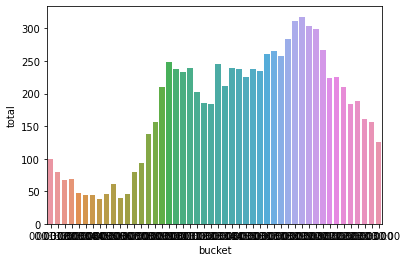

In [16]:
df = db.sql("""
    SELECT 
        make_time(date_part('hour', time_bucket(interval '30 minutes', datahora))  , date_part('minute', time_bucket(interval '30 minutes', datahora)) , 0) AS bucket, 
        count(1) AS total
    FROM 
        acidentes_clean 
    WHERE bucket IS NOT NULL
    GROUP BY 1 
    ORDER BY 1  asc
""").to_df() 

sns.barplot(data=df, x='bucket', y='total' )

<AxesSubplot:xlabel='bucket', ylabel='total'>

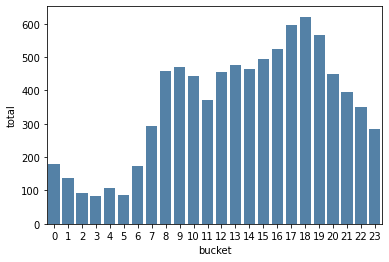

In [6]:
df = db.sql("""
    SELECT 
        date_part('hour', time_bucket(interval '60 minutes', datahora)) AS bucket, 
        count(1) AS total
    FROM 
        acidentes_clean 
    WHERE bucket IS NOT NULL
    GROUP BY 1 
    ORDER BY 1 ASC
""").to_df()

sns.barplot(data=df, x='bucket', y='total', color='steelblue' )

1. É bastante complicado juntar os dados do waze aos dados dos acidentes.
2. Existe um gap temporal no dados do waze de 2018-10-31 23:30:02 até 2019-08-01 00:04:13.162 
3. Mesmo fazer o cruzamento dos acidentes com objectos do gps nome das ruas se torna complicado
   1. Usar o nome das ruas não vair fazer correlação em todos os acidentes pois alguns nomes sao diferetes ou não se sabe a freguesia
   2. Por próximidade de gps não é possível garantir que se trata da estrada correct
4. Os dados tempo ... ?
5. O interessante seria entender os fenomentos de cada estrada e entender o que leva a que ocorra acidentes...
6. O data set mais completo é relativo aos dodos da ANSR
7. Vamos focar análise nesse conjuto de dados


Close db conneection to remove the lock on the file

In [18]:
db.sql(" SELECT count(1) FROM ansr_acidentes")

┌──────────┐
│ count(1) │
│  int64   │
├──────────┤
│     2768 │
└──────────┘

In [19]:
db.sql(""" SELECT "Tipo Natureza", count(1) FROM main.ansr_acidentes GROUP BY 1 """)

┌───────────────┬──────────┐
│ Tipo Natureza │ count(1) │
│    varchar    │  int64   │
├───────────────┼──────────┤
│ Despiste      │      521 │
│ Atropelamento │      674 │
│ Colisão       │     1573 │
└───────────────┴──────────┘

In [10]:
db.sql(""" SELECT "Tipos Vias", count(1) AS COUNT, ROUND(COUNT(1)/2768*100, 3) || '%' AS '%'  FROM ansr_acidentes GROUP BY 1 ORDER BY 3 DESC""")

┌──────────────────────────────┬───────┬─────────┐
│          Tipos Vias          │ COUNT │    %    │
│           varchar            │ int64 │ varchar │
├──────────────────────────────┼───────┼─────────┤
│ Arruamento                   │  2515 │ 90.86%  │
│ IP- Itinerário Principal     │   103 │ 3.721%  │
│ A  - Auto-Estrada            │   101 │ 3.649%  │
│ IC - Itinerário Complementar │    36 │ 1.301%  │
│ Outra Via                    │    10 │ 0.361%  │
│ PNT - Ponte                  │     3 │ 0.108%  │
└──────────────────────────────┴───────┴─────────┘

In [21]:
db.sql(""" SELECT "Lesões a 30 dias", count(1) FROM ansr_acidentes_passageiros GROUP BY 1 """)

┌──────────────────┬──────────┐
│ Lesões a 30 dias │ count(1) │
│     varchar      │  int64   │
├──────────────────┼──────────┤
│ Ferido leve      │      627 │
│ Ferido grave     │        1 │
│ Morto            │        3 │
└──────────────────┴──────────┘

In [22]:
db.sql(""" 
SELECT 
	freguesia,
	"Nome arruamento" AS nome_arruamento, 
	count(1) AS COUNT, 
	ROUND(COUNT(1)/2768*100, 3) || '%' AS '%'  
FROM ansr_acidentes 
WHERE nome_arruamento IS NOT NULL
GROUP BY 1,2 
ORDER BY 3
DESC LIMIT 23
""")

┌─────────────────────────┬───────────────────────────────────┬───────┬─────────┐
│        Freguesia        │          nome_arruamento          │ COUNT │    %    │
│         varchar         │              varchar              │ int64 │ varchar │
├─────────────────────────┼───────────────────────────────────┼───────┼─────────┤
│ Avenidas Novas          │ Avenida República                 │    43 │ 1.553%  │
│ São Domingos de Benfica │ Avenida Eusébio da Silva Ferreira │    31 │ 1.12%   │
│ Alvalade                │ Avenida Marechal Craveiro Lopes   │    31 │ 1.12%   │
│ Arroios                 │ Avenida Almirante Reis            │    31 │ 1.12%   │
│ Lumiar                  │ Calçada Carriche                  │    30 │ 1.084%  │
│ Alvalade                │ Campo Grande                      │    29 │ 1.048%  │
│ Santo António           │ Avenida Liberdade                 │    25 │ 0.903%  │
│ Estrela                 │ Avenida 24 de Julho               │    25 │ 0.903%  │
│ Santa Maria do

In [12]:
db.sql(""" 
CREATE OR REPLACE TEMP TABLE ACIDENTES_RUA_GRAVIDADE AS
SELECT 	
	freguesia, 
	rua,  
	SUM(cond_ileso) AS ileso, 
	SUM(passageiro_leves + cond_leves) AS leves, 
	SUM(passageiro_graves + cond_graves) AS graves, 
	SUM(passageiro_mortes + cond_mortes) AS mortes,      
	SUM(total_feridos) total,
	( 100 * mortes + 10 * graves + 3 * leves) AS INDICADOR_DE_GRAVIDADE, 
	( 30  * mortes + 10 * graves + 3 * leves) AS INDICADOR_DE_GRAVIDADE_SOFT
FROM
	(
	SELECT *, passageiro_leves + passageiro_graves + passageiro_mortes  + cond_leves + cond_graves + cond_mortes as total_feridos
	FROM
		(
		SELECT 
			a.IdAcidente, a.freguesia, a."Nome arruamento" AS rua,
			(SELECT count(1)	FROM ansr_acidentes_veic_cond cond 		WHERE cond.IdAcidente  = a.IdAcidente 	AND cond."Lesões a 30 dias" = 'Ileso') 			AS cond_ileso,
			(SELECT count(1)	FROM ansr_acidentes_veic_cond cond 		WHERE cond.IdAcidente  = a.IdAcidente 	AND cond."Lesões a 30 dias" = 'Ferido leve') 	AS cond_leves,
			(SELECT count(1)	FROM ansr_acidentes_veic_cond cond 		WHERE cond.IdAcidente  = a.IdAcidente 	AND cond."Lesões a 30 dias" = 'Ferido grave') 	AS cond_graves,
			(SELECT count(1)	FROM ansr_acidentes_veic_cond cond 		WHERE cond.IdAcidente  = a.IdAcidente 	AND cond."Lesões a 30 dias" = 'Morto') 			AS cond_mortes,
			(SELECT count(1)	FROM ansr_acidentes_passageiros pass 	where pass.IdAcidente  = a.IdAcidente 	AND pass."Lesões a 30 dias" = 'Ferido leve')	AS passageiro_leves, 
			(SELECT count(1)	FROM ansr_acidentes_passageiros pass 	where pass.IdAcidente = a.IdAcidente	AND pass."Lesões a 30 dias" = 'Ferido grave')	AS passageiro_graves, 
			(SELECT count(1)	FROM ansr_acidentes_passageiros pass 	where pass.IdAcidente = a.IdAcidente	AND pass."Lesões a 30 dias"	= 'Morto') 			AS passageiro_mortes 
		FROM ansr_acidentes a
		WHERE rua IS NOT NULL
		)
	)
GROUP BY 1, 2
""")

Ruas com mortes

In [16]:
db.sql(""" 
SELECT freguesia, rua, mortes
FROM
	ACIDENTES_RUA_GRAVIDADE 
WHERE mortes > 0
ORDER BY indicador_de_gravidade DESC
LIMIT 10
""")

┌─────────────────────────┬────────────────────────────────────────┬────────┐
│        Freguesia        │                  rua                   │ mortes │
│         varchar         │                varchar                 │ int128 │
├─────────────────────────┼────────────────────────────────────────┼────────┤
│ Alvalade                │ Avenida Marechal Craveiro Lopes        │      1 │
│ Santa Maria dos Olivais │ Avenida Cidade do Porto                │      1 │
│ Alvalade                │ Avenida Professor Egas Moniz           │      1 │
│ Penha de França         │ Avenida Marechal Francisco Costa Gomes │      1 │
│ Alcântara               │ Estrada do Alvito                      │      1 │
└─────────────────────────┴────────────────────────────────────────┴────────┘

In [ ]:
db.sql(""" 
SELECT freguesia, rua, total
FROM
	ACIDENTES_RUA_GRAVIDADE 
ORDER BY total DESC
LIMIT 10
""")

Top 10 ruas com fridos

In [15]:
db.sql(""" 
SELECT freguesia, rua, total
FROM
	ACIDENTES_RUA_GRAVIDADE 
ORDER BY total DESC
LIMIT 10
""")

┌─────────────────────────┬───────────────────────────────────┬────────┐
│        Freguesia        │                rua                │ total  │
│         varchar         │              varchar              │ int128 │
├─────────────────────────┼───────────────────────────────────┼────────┤
│ São Domingos de Benfica │ Avenida Eusébio da Silva Ferreira │     39 │
│ Lumiar                  │ Calçada Carriche                  │     39 │
│ Alvalade                │ Avenida Marechal Craveiro Lopes   │     38 │
│ Avenidas Novas          │ Avenida República                 │     36 │
│ Lumiar                  │ Avenida Padre Cruz                │     29 │
│ Santo António           │ Avenida Liberdade                 │     29 │
│ Arroios                 │ Avenida Almirante Reis            │     28 │
│ Santa Maria dos Olivais │ Avenida Berlim                    │     27 │
│ Santa Maria dos Olivais │ Avenida Marechal Gomes da Costa   │     26 │
│ Alvalade                │ Campo Grande           

In [19]:
db.sql(""" 
SELECT freguesia, rua, indicador_de_gravidade 
FROM
	ACIDENTES_RUA_GRAVIDADE 
ORDER BY indicador_de_gravidade  DESC
LIMIT 20
""")

┌─────────────────────────┬────────────────────────────────────────┬────────────────────────┐
│        Freguesia        │                  rua                   │ INDICADOR_DE_GRAVIDADE │
│         varchar         │                varchar                 │         int128         │
├─────────────────────────┼────────────────────────────────────────┼────────────────────────┤
│ Alvalade                │ Avenida Marechal Craveiro Lopes        │                    232 │
│ Santa Maria dos Olivais │ Avenida Cidade do Porto                │                    143 │
│ Lumiar                  │ Calçada Carriche                       │                    124 │
│ Alvalade                │ Avenida Professor Egas Moniz           │                    124 │
│ São Domingos de Benfica │ Avenida Eusébio da Silva Ferreira      │                    117 │
│ Penha de França         │ Avenida Marechal Francisco Costa Gomes │                    116 │
│ Avenidas Novas          │ Avenida República               

In [42]:
db.sql(""" 
SELECT freguesia, rua, indicador_de_gravidade_soft
FROM
	ACIDENTES_RUA_GRAVIDADE 
ORDER BY indicador_de_gravidade_soft DESC
LIMIT 20
""")

┌─────────────────────────┬───────────────────────────────────┬─────────────────────────────┐
│        Freguesia        │                rua                │ INDICADOR_DE_GRAVIDADE_SOFT │
│         varchar         │              varchar              │           int128            │
├─────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ Alvalade                │ Avenida Marechal Craveiro Lopes   │                         162 │
│ Lumiar                  │ Calçada Carriche                  │                         124 │
│ São Domingos de Benfica │ Avenida Eusébio da Silva Ferreira │                         117 │
│ Avenidas Novas          │ Avenida República                 │                         115 │
│ Santo António           │ Avenida Liberdade                 │                          94 │
│ Lumiar                  │ Avenida Padre Cruz                │                          87 │
│ Arroios                 │ Avenida Almirante Reis          

In [22]:
db.sql(""" 
SELECT freguesia, rua, leves, graves, mortes, total, indicador_de_gravidade
FROM
	ACIDENTES_RUA_GRAVIDADE 
ORDER BY indicador_de_gravidade_soft DESC
LIMIT 10
""")

┌──────────────────────┬──────────────────────────────────┬────────┬────────┬────────┬────────┬────────────────────────┐
│      Freguesia       │               rua                │ leves  │ graves │ mortes │ total  │ INDICADOR_DE_GRAVIDADE │
│       varchar        │             varchar              │ int128 │ int128 │ int128 │ int128 │         int128         │
├──────────────────────┼──────────────────────────────────┼────────┼────────┼────────┼────────┼────────────────────────┤
│ Alvalade             │ Avenida Marechal Craveiro Lopes  │     34 │      3 │      1 │     38 │                    232 │
│ Lumiar               │ Calçada Carriche                 │     38 │      1 │      0 │     39 │                    124 │
│ São Domingos de Be…  │ Avenida Eusébio da Silva Ferre…  │     39 │      0 │      0 │     39 │                    117 │
│ Avenidas Novas       │ Avenida República                │     35 │      1 │      0 │     36 │                    115 │
│ Santo António        │ Avenida

<AxesSubplot:xlabel='AGE', ylabel='TOTAL'>

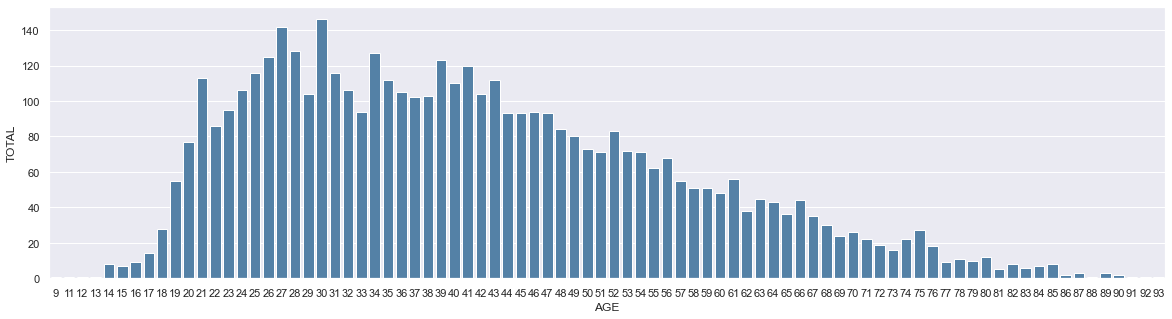

In [23]:
df = db.sql(""" SELECT idade::INTEGER AS AGE, COUNT(1) AS TOTAL  FROM ansr_acidentes_veic_cond WHERE AGE IS NOT NULL  GROUP BY 1 order by 1 """).to_df() 

sns.set(rc={'figure.figsize':(20, 5)})
sns.barplot(data=df, x='AGE', y='TOTAL', color='steelblue'  )
 

In [26]:
db.sql(""" SELECT "Categoria Veículos", count(1) FROM ansr_acidentes_veic_cond GROUP BY 1 ORDER BY 2 DESC """)

┌───────────────────────────────┬──────────┐
│      Categoria Veículos       │ count(1) │
│            varchar            │  int64   │
├───────────────────────────────┼──────────┤
│ Automóvel ligeiro             │     3349 │
│ Motociclo cilindrada <= 125cc │      710 │
│ Motociclo cilindrada > 125cc  │      338 │
│ Automóvel pesado              │      118 │
│ Ciclomotor                    │      114 │
│ Velocípede                    │       87 │
│ Velocípede com motor          │       79 │
│ Triciclo                      │       23 │
│ Veículo sobre carris          │        8 │
│ Desconhecido                  │        3 │
│ Quadriciclo                   │        2 │
│ NÃO DEFINIDO                  │        2 │
│ Veículo agrícola              │        1 │
├───────────────────────────────┴──────────┤
│ 13 rows                        2 columns │
└──────────────────────────────────────────┘

In [27]:
db.sql(""" SELECT "Traçado 1",  count(1) FROM ansr_acidentes  GROUP BY ALL ORDER BY 2 DESC """)

┌──────────────┬──────────┐
│  Traçado 1   │ count(1) │
│   varchar    │  int64   │
├──────────────┼──────────┤
│ Recta        │     2327 │
│ Curva        │      422 │
│ NÃO DEFINIDO │       19 │
└──────────────┴──────────┘

In [28]:
db.sql(""" SELECT "Traçado 1", "Traçado 2", count(1) FROM ansr_acidentes  GROUP BY ALL ORDER BY 3 DESC """)

┌──────────────┬────────────────┬──────────┐
│  Traçado 1   │   Traçado 2    │ count(1) │
│   varchar    │    varchar     │  int64   │
├──────────────┼────────────────┼──────────┤
│ Recta        │ Em patamar     │     1578 │
│ Recta        │ Com inclinação │      737 │
│ Curva        │ Com inclinação │      221 │
│ Curva        │ Em patamar     │      199 │
│ NÃO DEFINIDO │ NÃO DEFINIDO   │       19 │
│ Recta        │ Em Lomba       │        7 │
│ Recta        │ NÃO DEFINIDO   │        5 │
│ Curva        │ Em Lomba       │        2 │
└──────────────┴────────────────┴──────────┘

In [9]:
db.sql(""" 
SELECT 
    "Traçado 1" t1, "Traçado 2" t2, "Traçado 3" t3, count(1) 
FROM 
    ansr_acidentes 
WHERE 
    t3 = 'Berma pavimentada' OR t3 = 'Sem berma ou impraticável'  
GROUP BY ALL 
HAVING count(1) > 10
ORDER BY 4 DESC

 """)

┌─────────┬────────────────┬───────────────────────────┬──────────┐
│   t1    │       t2       │            t3             │ count(1) │
│ varchar │    varchar     │          varchar          │  int64   │
├─────────┼────────────────┼───────────────────────────┼──────────┤
│ Recta   │ Em patamar     │ Berma pavimentada         │     1045 │
│ Recta   │ Em patamar     │ Sem berma ou impraticável │      499 │
│ Recta   │ Com inclinação │ Berma pavimentada         │      406 │
│ Recta   │ Com inclinação │ Sem berma ou impraticável │      320 │
│ Curva   │ Em patamar     │ Berma pavimentada         │      129 │
│ Curva   │ Com inclinação │ Berma pavimentada         │      112 │
│ Curva   │ Com inclinação │ Sem berma ou impraticável │      106 │
│ Curva   │ Em patamar     │ Sem berma ou impraticável │       67 │
└─────────┴────────────────┴───────────────────────────┴──────────┘

In [24]:
db.close()